In [1]:
%pip install -Uq upgini
%pip install -Uq shap
import pandas as pd
import numpy as np
from os.path import exists

     |████████████████████████████████| 91 kB 5.2 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 32.3 MB/s 
     |████████████████████████████████| 2.0 MB 74.3 MB/s 
     |████████████████████████████████| 12.2 MB 19.8 MB/s 
     |████████████████████████████████| 575 kB 7.2 MB/s 


In [12]:
df_path = "us_zip_elections.csv" if exists("us_zip_elections.csv") else "https://github.com/upgini/upgini/raw/main/notebooks/us_zip_elections.csv"
df = pd.read_csv(df_path)
df.head(5)

,country,postal_code,STATENAME,ID,DISTRICT,DEM,REP
0,US,00501,New York,36113114001,1,0.0,1.0
1,US,00544,New York,36113114001,1,0.0,1.0
2,US,01001,Massachusetts,25113114001,1,1.0,0.0
3,US,01002,Massachusetts,25113114002,2,1.0,0.0
4,US,01003,Massachusetts,25113114002,2,1.0,0.0


In [27]:
popul_by_county=df.groupby(['state_county'])['population'].sum().reset_index()
popul_by_county.columns=['state_county', 'population_county']

In [29]:
df=df.merge(popul_by_county, on='state_county')


In [47]:
df.head(3)

,country,postal_code,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone,state_county,delta_2016_11_08,delta_2016_12_10,delta_2018_11_06,delta_2020_11_03,delta_2022_11_08,population_county
0,US,601,18.18027,-66.75266,Adjuntas,PR,Puerto Rico,True,NaN,16773.0,100.5,72001,Adjuntas,"{""72001"": 98.73, ""72141"": 1.27}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico,PR_Adjuntas,NaN,NaN,NaN,NaN,NaN,16773.0
1,US,602,18.36075,-67.17541,Aguada,PR,Puerto Rico,True,NaN,37083.0,472.1,72003,Aguada,"{""72003"": 100}",Aguada,72003,False,False,America/Puerto_Rico,PR_Aguada,NaN,NaN,NaN,NaN,NaN,37083.0
2,US,603,18.45744,-67.12225,Aguadilla,PR,Puerto Rico,True,NaN,45652.0,513.2,72005,Aguadilla,"{""72005"": 99.76, ""72099"": 0.24}",Aguadilla|Moca,72005|72099,False,False,America/Puerto_Rico,PR_Aguadilla,NaN,NaN,NaN,NaN,NaN,51552.0


In [64]:
df_train1=df.loc[  ((df['delta_2016_11_08']<0) | (df['delta_2016_11_08']>0)) ]
df_train1=df_train1.loc[((df_train1['delta_2016_12_10']==0) )]
df_train1=df_train1.loc[((df_train1['delta_2018_11_06']<0) | (df_train1['delta_2018_11_06']>0))]

df_train1.columns=['country', 'postal_code', 'lat', 'lng', 'city', 'state_id',
       'state_name', 'zcta', 'parent_zcta', 'population', 'density',
       'county_fips', 'county_name', 'county_weights', 'county_names_all',
       'county_fips_all', 'imprecise', 'military', 'timezone', 'state_county',
       'last_result', 'delta_2016_12_10', 'target_result',
       'delta_2020_11_03', 'delta_2022_11_08', 'population_county']

df_train1=df_train1.drop(['delta_2016_12_10', 'delta_2020_11_03', 'delta_2022_11_08'], axis=1)
df_train1['last_result_share']=df_train1['last_result']/df_train1['population_county']
df_train1['election_date']='2018-11-06'

In [65]:
df_train2=df.loc[  ((df['delta_2016_11_08']<0) | (df['delta_2016_11_08']>0)) ]
df_train2=df_train2.loc[((df_train2['delta_2016_12_10']==0) & (df_train2['delta_2018_11_06']==0) )]
df_train2=df_train2.loc[((df_train2['delta_2020_11_03']<0) | (df_train2['delta_2020_11_03']>0))]

df_train2.columns=['country', 'postal_code', 'lat', 'lng', 'city', 'state_id',
       'state_name', 'zcta', 'parent_zcta', 'population', 'density',
       'county_fips', 'county_name', 'county_weights', 'county_names_all',
       'county_fips_all', 'imprecise', 'military', 'timezone', 'state_county',
       'last_result', 'delta_2016_12_10', 'delta_2018_11_06',
       'target_result', 'delta_2022_11_08', 'population_county']

df_train2=df_train2.drop(['delta_2016_12_10', 'delta_2018_11_06', 'delta_2022_11_08'], axis=1)
df_train2['last_result_share']=df_train2['last_result']/df_train2['population_county']
df_train2['election_date']='2020-11-03'

In [66]:
df_train3=df.loc[  ((df['delta_2016_11_08']<0) | (df['delta_2016_11_08']>0)) ]
df_train3=df_train3.loc[((df_train3['delta_2016_12_10']==0) & (df_train3['delta_2018_11_06']==0) & (df_train3['delta_2020_11_03']==0))]
df_train3=df_train3.loc[((df_train3['delta_2022_11_08']<0) | (df_train3['delta_2022_11_08']>0))]

df_train3.columns=['country', 'postal_code', 'lat', 'lng', 'city', 'state_id',
       'state_name', 'zcta', 'parent_zcta', 'population', 'density',
       'county_fips', 'county_name', 'county_weights', 'county_names_all',
       'county_fips_all', 'imprecise', 'military', 'timezone', 'state_county',
       'last_result', 'delta_2016_12_10', 'delta_2018_11_06',
       'delta_2020_11_03', 'target_result', 'population_county']

df_train3=df_train3.drop(['delta_2016_12_10', 'delta_2018_11_06', 'delta_2020_11_03'], axis=1)
df_train3['last_result_share']=df_train3['last_result']/df_train3['population_county']
df_train3['election_date']='2022-11-08'

In [67]:
df_train4=df.loc[  ((df['delta_2018_11_06']<0) | (df['delta_2018_11_06']>0)) ]
df_train4=df_train4.loc[(  (df_train4['delta_2020_11_03']==0))]
df_train4=df_train4.loc[((df_train4['delta_2022_11_08']<0) | (df_train4['delta_2022_11_08']>0))]

df_train4.columns=['country', 'postal_code', 'lat', 'lng', 'city', 'state_id',
       'state_name', 'zcta', 'parent_zcta', 'population', 'density',
       'county_fips', 'county_name', 'county_weights', 'county_names_all',
       'county_fips_all', 'imprecise', 'military', 'timezone', 'state_county',
       'delta_2016_11_08', 'delta_2016_12_10', 'last_result',
       'delta_2020_11_03', 'target_result', 'population_county']

df_train4=df_train4.drop(['delta_2016_12_10', 'delta_2016_11_08', 'delta_2020_11_03'], axis=1)
df_train4['last_result_share']=df_train4['last_result']/df_train4['population_county']
df_train4['election_date']='2022-11-08'

In [71]:
df_train5=df.loc[  ((df['delta_2018_11_06']<0) | (df['delta_2018_11_06']>0)) ]
df_train5=df_train5.loc[((df_train5['delta_2020_11_03']<0) | (df_train5['delta_2020_11_03']>0))]

df_train5.columns=['country', 'postal_code', 'lat', 'lng', 'city', 'state_id',
       'state_name', 'zcta', 'parent_zcta', 'population', 'density',
       'county_fips', 'county_name', 'county_weights', 'county_names_all',
       'county_fips_all', 'imprecise', 'military', 'timezone', 'state_county',
       'delta_2016_11_08', 'delta_2016_12_10', 'last_result',
       'target_result', 'delta_2022_11_08', 'population_county']

df_train5=df_train5.drop(['delta_2016_12_10', 'delta_2016_11_08', 'delta_2022_11_08'], axis=1)
df_train5['last_result_share']=df_train5['last_result']/df_train5['population_county']
df_train5['election_date']='2020-11-03'

In [72]:
df_train6=df.loc[  ((df['delta_2020_11_03']<0) | (df['delta_2020_11_03']>0)) ]
df_train6=df_train6.loc[((df_train6['delta_2022_11_08']<0) | (df_train6['delta_2022_11_08']>0))]

df_train6.columns=['country', 'postal_code', 'lat', 'lng', 'city', 'state_id',
       'state_name', 'zcta', 'parent_zcta', 'population', 'density',
       'county_fips', 'county_name', 'county_weights', 'county_names_all',
       'county_fips_all', 'imprecise', 'military', 'timezone', 'state_county',
       'delta_2016_11_08', 'delta_2016_12_10', 'delta_2018_11_06',
       'last_result', 'target_result', 'population_county']

df_train6=df_train6.drop(['delta_2016_12_10', 'delta_2016_11_08', 'delta_2018_11_06'], axis=1)
df_train6['last_result_share']=df_train6['last_result']/df_train6['population_county']
df_train6['election_date']='2022-11-08'

In [128]:
df_train_all=pd.concat([df_train1, df_train2,df_train3,df_train4,df_train5,df_train6])

In [129]:
df_train_all['last_result_party']=np.where(df_train_all['last_result']>0, 1, 0)
df_train_all['target_result_party']=np.where(df_train_all['target_result']>0, 1, 0)

In [130]:
df_train_all.head(3)

,country,postal_code,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone,state_county,last_result,target_result,population_county,last_result_share,election_date,last_result_party,target_result_party
1431,US,5001,43.67309,-72.37943,White River Junction,VT,Vermont,True,NaN,9317.0,84.2,50027,Windsor,"{""50027"": 100}",Windsor,50027,False,False,America/New_York,VT_Windsor,-783.0,-624.0,55324.0,-0.014153,2018-11-06,0,0
1432,US,5009,43.64769,-72.34395,White River Junction,VT,Vermont,True,NaN,NaN,NaN,50027,Windsor,"{""50027"": 100}",Windsor,50027,False,False,America/New_York,VT_Windsor,-783.0,-624.0,55324.0,-0.014153,2018-11-06,0,0
1433,US,5030,43.39989,-72.40981,Ascutney,VT,Vermont,True,NaN,NaN,NaN,50027,Windsor,"{""50027"": 100}",Windsor,50027,False,False,America/New_York,VT_Windsor,-783.0,-624.0,55324.0,-0.014153,2018-11-06,0,0


In [131]:
df_train_all['election_date'] =pd.to_datetime(df_train_all['election_date'], format='%Y-%m-%d')

In [132]:
df_train_all

,country,postal_code,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone,state_county,last_result,target_result,population_county,last_result_share,election_date,last_result_party,target_result_party
1431,US,5001,43.67309,-72.37943,White River Junction,VT,Vermont,True,NaN,9317.0,84.2,50027,Windsor,"{""50027"": 100}",Windsor,50027,False,False,America/New_York,VT_Windsor,-783.00,-624.00,55324.0,-0.014153,2018-11-06,0,0
1432,US,5009,43.64769,-72.34395,White River Junction,VT,Vermont,True,NaN,NaN,NaN,50027,Windsor,"{""50027"": 100}",Windsor,50027,False,False,America/New_York,VT_Windsor,-783.00,-624.00,55324.0,-0.014153,2018-11-06,0,0
1433,US,5030,43.39989,-72.40981,Ascutney,VT,Vermont,True,NaN,NaN,NaN,50027,Windsor,"{""50027"": 100}",Windsor,50027,False,False,America/New_York,VT_Windsor,-783.00,-624.00,55324.0,-0.014153,2018-11-06,0,0
1434,US,5031,43.72361,-72.58720,Barnard,VT,Vermont,True,NaN,97.0,15.0,50027,Windsor,"{""50027"": 100}",Windsor,50027,False,False,America/New_York,VT_Windsor,-783.00,-624.00,55324.0,-0.014153,2018-11-06,0,0
1435,US,5032,43.80193,-72.65708,Bethel,VT,Vermont,True,NaN,2823.0,16.0,50027,Windsor,"{""50027"": 100}",Windsor,50027,False,False,America/New_York,VT_Windsor,-783.00,-624.00,55324.0,-0.014153,2018-11-06,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32933,US,97913,43.64688,-117.28131,Nyssa,OR,Oregon,True,NaN,5007.0,4.9,41045,Malheur,"{""41045"": 99.86, ""16075"": 0.14}",Malheur|Payette,41045|16075,False,False,America/Boise,OR_Malheur,4522.44,4166.22,30613.0,0.147729,2022-11-08,1,1
32934,US,97914,44.11085,-117.07383,Ontario,OR,Oregon,True,NaN,19281.0,28.6,41045,Malheur,"{""41045"": 100}",Malheur,41045,False,False,America/Boise,OR_Malheur,4522.44,4166.22,30613.0,0.147729,2022-11-08,1,1
32935,US,97917,43.54150,-118.11651,Riverside,OR,Oregon,True,NaN,NaN,NaN,41045,Malheur,"{""41045"": 100}",Malheur,41045,False,False,America/Boise,OR_Malheur,4522.44,4166.22,30613.0,0.147729,2022-11-08,1,1
32936,US,97918,43.96255,-117.38073,Vale,OR,Oregon,True,NaN,4533.0,3.0,41045,Malheur,"{""41045"": 100}",Malheur,41045,False,False,America/Boise,OR_Malheur,4522.44,4166.22,30613.0,0.147729,2022-11-08,1,1


In [133]:
df_train_all=df_train_all.reset_index(drop=True)

df_train_all=df_train_all.sort_values(['election_date']).reset_index(drop=True)
df_train_all

,country,postal_code,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone,state_county,last_result,target_result,population_county,last_result_share,election_date,last_result_party,target_result_party
0,US,5001,43.67309,-72.37943,White River Junction,VT,Vermont,True,NaN,9317.0,84.2,50027,Windsor,"{""50027"": 100}",Windsor,50027,False,False,America/New_York,VT_Windsor,-783.00,-624.00,55324.0,-0.014153,2018-11-06,0,0
1,US,47959,40.86603,-86.89786,Monon,IN,Indiana,True,NaN,2630.0,14.9,18181,White,"{""18181"": 85.23, ""18073"": 11.71, ""18131"": 3.06}",White|Jasper|Pulaski,18181|18073|18131,False,False,America/Indiana/Indianapolis,IN_White,2873.00,2364.00,26766.0,0.107338,2018-11-06,1,1
2,US,47960,40.78261,-86.74938,Monticello,IN,Indiana,True,NaN,14735.0,48.1,18181,White,"{""18181"": 84.16, ""18015"": 15.58, ""18131"": 0.26}",White|Carroll|Pulaski,18181|18015|18131,False,False,America/Indiana/Indianapolis,IN_White,2873.00,2364.00,26766.0,0.107338,2018-11-06,1,1
3,US,47980,40.75393,-86.90131,Reynolds,IN,Indiana,True,NaN,1041.0,7.4,18181,White,"{""18181"": 100}",White,18181,False,False,America/Indiana/Indianapolis,IN_White,2873.00,2364.00,26766.0,0.107338,2018-11-06,1,1
4,US,47995,40.75861,-87.03290,Wolcott,IN,Indiana,True,NaN,2002.0,9.4,18181,White,"{""18181"": 95.85, ""18007"": 2.38, ""18073"": 1.77}",White|Benton|Jasper,18181|18007|18073,False,False,America/Indiana/Indianapolis,IN_White,2873.00,2364.00,26766.0,0.107338,2018-11-06,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50773,US,46777,40.87248,-85.15236,Ossian,IN,Indiana,True,NaN,6170.0,41.2,18179,Wells,"{""18179"": 92.3, ""18003"": 4.95, ""18001"": 2.75}",Wells|Allen|Adams,18179|18003|18001,False,False,America/Indiana/Indianapolis,IN_Wells,5125.00,5758.83,27771.0,0.184545,2022-11-08,1,1
50774,US,46770,40.82980,-85.31873,Markle,IN,Indiana,True,NaN,3062.0,22.5,18179,Wells,"{""18179"": 61.35, ""18069"": 38.65}",Wells|Huntington,18179|18069,False,False,America/Indiana/Indianapolis,IN_Wells,5125.00,5758.83,27771.0,0.184545,2022-11-08,1,1
50775,US,46766,40.70984,-85.29424,Liberty Center,IN,Indiana,True,NaN,883.0,23.7,18179,Wells,"{""18179"": 100}",Wells,18179,False,False,America/Indiana/Indianapolis,IN_Wells,5125.00,5758.83,27771.0,0.184545,2022-11-08,1,1
50776,US,46974,40.94839,-85.93041,Roann,IN,Indiana,True,NaN,1832.0,16.9,18169,Wabash,"{""18169"": 59.82, ""18103"": 40.18}",Wabash|Miami,18169|18103,False,False,America/Indiana/Indianapolis,IN_Wabash,4499.00,5516.00,32050.0,0.140374,2022-11-08,1,1


In [178]:
df_train_all.to_parquet('/content/drive/MyDrive/us_zip_elections.parquet')

In [134]:
train=df_train_all.loc[df_train_all['election_date']<'2022-11-08']
train=train.drop_duplicates(subset=['postal_code'], keep='last')
test=df_train_all.loc[df_train_all['election_date']=='2022-11-08']

In [101]:
%%time
from upgini import FeaturesEnricher, SearchKey
from upgini.metadata import RuntimeParameters,CVType

enricher = FeaturesEnricher(
    search_keys={
        'country': SearchKey.COUNTRY,
        'postal_code': SearchKey.POSTAL_CODE,
        'election_date':SearchKey.DATE,
       
    }, 
   runtime_parameters = RuntimeParameters(properties={
        'google-cloud.mlBackendUrl': 'https://polars-test-74ml6lc4ha-nw.a.run.app',
        
    }),
    cv=CVType.time_series ,

    api_key='UOE9bdK62stiNVnZjQF6SeHccupKnFo78A1JkufO9Rw'
)
enricher.fit(train[['country', 'postal_code', 'population', 'density',
       'last_result',  'population_county',
       'last_result_share', 'election_date', 'last_result_party']], train.target_result_party,
             eval_set=[(test[['country', 'postal_code', 'population', 'density',
       'last_result',  'population_county',
       'last_result_share', 'election_date', 'last_result_party']], test.target_result_party)],
             calculate_metrics=True)

Detected task type: ModelTaskType.BINARY


Column name,Status,Description
target,All valid,All values in this column are good to go
postal_code,All valid,All values in this column are good to go
election_date,All valid,All values in this column are good to go
country,All valid,All values in this column are good to go


Running search request with search_id=70e6b6ad-1920-415b-a30c-70d2b1e2e8a2
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done


42 relevant feature(s) found with the search keys: ['country', 'postal_code', 'election_date']


,,last_result_share,0.424737,100.000000,numerical,
,,last_result,0.147414,100.000000,numerical,
,,population_county,0.095969,100.000000,numerical,
Upgini,Public/Comm. shared,f_location_country_postal_latitude_2e1eae46,0.041621,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_weather_country_date_postal_daylight_time_bea3cf0a,0.037600,21.444740,numerical,Free
Upgini,Public/Comm. shared,f_location_country_postal_longitude_585c92dc,0.032560,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_weather_country_date_postal_prcp_4d9ed1e1,0.020857,99.771653,numerical,Free
Upgini,Public/Comm. shared,f_weather_country_date_postal_delta_to_avg_snow_8bd64d2e,0.016698,97.970692,numerical,Free
Upgini,Public/Comm. shared,f_weather_country_date_postal_tobs_210f1c58,0.012317,91.723919,numerical,Free
Upgini,Public/Comm. shared,f_weather_country_date_postal_daylight_time_a79bd1f1,0.011364,78.555260,numerical,Free
Upgini,Public/Comm. shared,f_weather_country_date_postal_delta_to_avg_prcp_69cb1eca,0.009370,99.771653,numerical,Free


Calculating metrics...
Done

Quality metrics


,match_rate,baseline roc_auc,enriched roc_auc,uplift
,,,,
train,100.0,0.915854,0.922462,0.006608
eval 1,100.0,0.950074,0.956784,0.006710


CPU times: user 1min 1s, sys: 3.04 s, total: 1min 4s
Wall time: 16min 34s


In [136]:
df2=enricher.transform(test, max_features=10)

Column name,Status,Description
election_date,All valid,All values in this column are good to go
postal_code,All valid,All values in this column are good to go
country,All valid,All values in this column are good to go


Running search request with search_id=a5247894-8960-4e91-aa60-a2b0d2a1252b
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done


In [137]:
import pandas as pd
from sklearn.metrics import get_scorer
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np


CATBOOST_PARAMS = {
    "iterations": 50,
    "early_stopping_rounds": 5,
    "one_hot_max_size": 10,
    "verbose": False,
    "random_state": 42,
    "allow_writing_files": False,
}

scorer = get_scorer("roc_auc")
multiplier = 1
metric_name = "roc_auc"
cv = StratifiedKFold(n_splits=5, shuffle=False)
estimator = CatBoostClassifier(**CATBOOST_PARAMS)

In [167]:

X1 = df2.drop([
'country', 'postal_code', 'election_date', 'city', 'state_id', 'state_name', 'zcta', 'parent_zcta',
'county_name', 'county_weights', 'county_names_all', 'county_fips_all', 'imprecise',
'military', 'timezone', 'state_county', 'county_fips', 'lng', 'lat',
'f_location_country_postal_longitude_585c92dc',
'f_location_country_postal_latitude_2e1eae46',
'target_result_party', 'target_result'], axis=1)
y1=df2.target_result_party

In [168]:
from copy import deepcopy


etalon_model = deepcopy(estimator)
best_model=etalon_model.fit(X1, y1)


All-NaN slice encountered
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


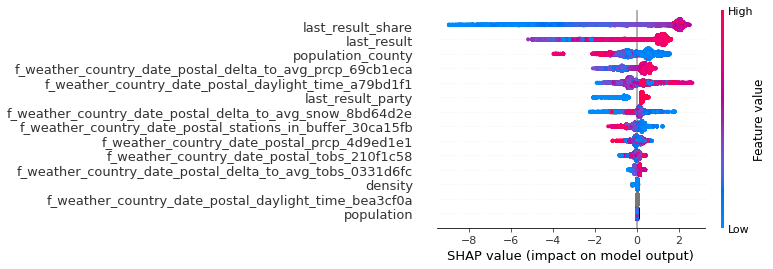

In [169]:
import shap

shap_test = shap.TreeExplainer(best_model).shap_values(X1)
shap.summary_plot(shap_test, X1,plot_size=None)

In [166]:
df2.groupby(['target_result_party'])['f_weather_country_date_postal_delta_to_avg_prcp_69cb1eca'].mean()

target_result_party
0     9.072786
1    12.687661
Name: f_weather_country_date_postal_delta_to_avg_prcp_69cb1eca, dtype: float64